In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use('default')
hep.style.use('ROOT')

$$ \LARGE p_i = \frac{1}{Q} e^{-\varepsilon_i /k_B T} = \frac{e^{-\varepsilon_i /k_B T}}{\sum^M_{j=1} e^{-\varepsilon_j /k_B T} }$$

According to Scipy this is the same as 
$$ \LARGE f(k) = \frac{ 1-e^{-\lambda}}{ 1-e^{-\lambda N}}e^{-\lambda k} $$
With $\lambda = 1/k_B T$, $k = \varepsilon_i$


## Write a routine that generates N initial conditions ($x_0 , p_0$) with a Boltzmann probability distribution for our ideal gas particle in the piston and calculates $W_c(x_0, p_0) + W_e(x_0, p_0)$ for each.

In [2]:
def generate_space(Npoints: int ,m: int=2,V: int = 2,L: int=20,kT: int=8,**kwargs) -> tuple: 
    ''' Generates Npoints of initial conditions with a boltzmann distribution for x0 and p0
    '''
    x0=stats.boltzmann.rvs(lambda_=1/kT,N=L,loc=0,size=Npoints,**kwargs)
    p0=stats.boltzmann.rvs(lambda_=1/kT,N=2*m*V,loc=-m*V,size=Npoints,**kwargs)
    return x0,p0


def work(x0 ,p0 ,m: int = 2 ,V: int = 2 ) -> tuple:  
    '''Calculates the compression work and expansion work done on the particle (We,Wc) respectively
    '''
    Wc = .5*m*V**2 + V*p0
    We = 2*V*p0
    return Wc,We


def calculate_work(Npoints,L=20,Lprime=19,V=2,m=2,**kwargs):
    x0,p0 = generate_space(Npoints,m,V,L,kT=8,**kwargs)
    Wctemp,Wetemp = work(x0,p0,m,V)
    deltaL = L-Lprime
    x1 = (deltaL)*(1-p0/(m*V)) 
    x2 = (deltaL)*(-2*p0/(m*V))
    xcut = ((x0>x1) | (x0>x2)) 

    Wctemp[x0>=x1] = 0
    Wetemp[xcut & p0>=-m*V ] = 0 
    Wc= Wctemp[:]
    We= Wetemp[:]
    return Wc,We

# Calculate the average work done by the piston $W_c +W_e$. How big must N be before you get a reliable average? 

Text(1, 0, 'Number of initial conditions')

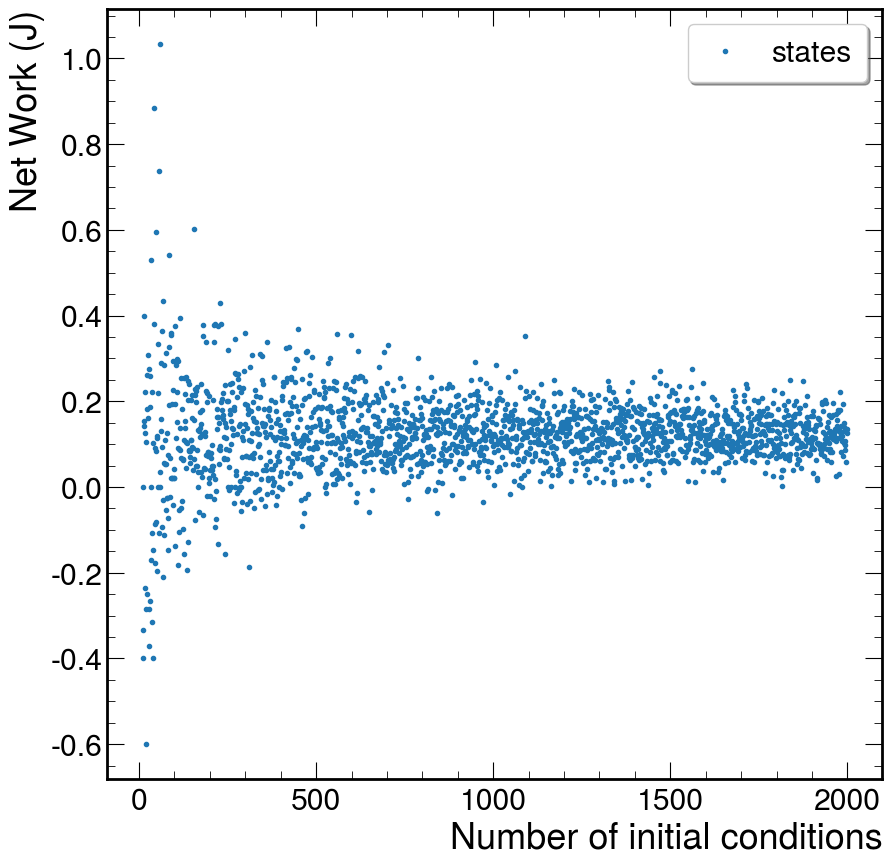

In [3]:
mlist=[]
start,stop,step=10,2_000,1
for i in range(start,stop,step):
    Wc,We = calculate_work(i)
    Wnet = Wc + We
    mean = Wnet.mean()
    mlist.append(mean)
plt.plot(range(start,stop,step),mlist,'.',label='states');
# plt.title('')
plt.legend(frameon=True,shadow=True)
plt.ylabel('Net Work (J)')
plt.xlabel('Number of initial conditions')



N must be at least around 500 to be reliable based on this plot to show how the average W converges to a value.


## Does your average obey eqn 4.18?
Eqn. 4.18 is 
$$ \huge \overline{W_c + W_e} \geq 0$$
Yes it does.


In [4]:
np.mean(Wc+We)

0.12506253126563283

## Use your routine with $N = 1,000$ to calculate Jarzynski’s exponentially weighted average $\overline{{\exp (−W/k_B T)}}$ in eqn 4.19, and compare to $\exp (-\overline{W}/ k_B T )$. Do this 200 times, and plot a histogram of each. Does the Jarzynski equality appear to hold?

One iteration

In [5]:
Wc,We = calculate_work(1_000) # N = 1000
Wnet = Wc + We
mean = Wnet.mean() # Eq 4.18
kT=8

print(f"Jarzynki's weighted average {np.mean(np.exp(-Wnet/kT)):.4f}")
print(f"exp(bar(-W)/kT) = {np.exp(-mean/kT):.4f}")


Jarzynki's weighted average 1.0035
exp(bar(-W)/kT) = 0.9773


200 iterations and now plotting the histograms

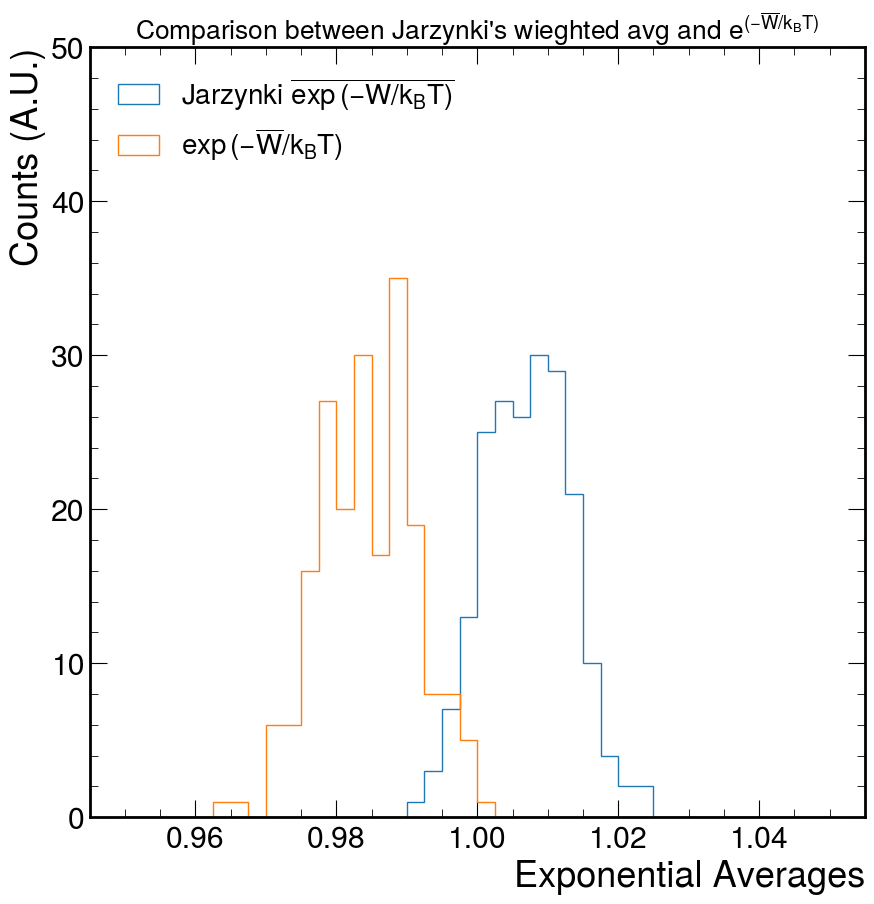

In [10]:
Jar_avg=[]
expW_kT = []
for i in range(200):
    Wc,We = calculate_work(1_000) # N = 1000
    Wnet = Wc + We
    mean = Wnet.mean()
    Jar_avg.append(np.mean( np.exp(-Wnet/kT) ))
    expW_kT.append(np.exp(-mean/kT))

bins=np.arange(0.95,1.05,.0025)
plt.hist(Jar_avg,histtype='step',label="Jarzynki $\overline{\exp{(-W/k_BT)}}$",bins=bins)
plt.hist(expW_kT,histtype='step',label="$\exp{(-\overline{W}/k_B T)}$",bins=bins)
plt.legend(loc=2,fontsize=20)
plt.ylabel('Counts (A.U.)')
plt.xlabel('Exponential Averages')
plt.title(r"Comparison between Jarzynki's wieghted avg and $e^{(-\overline{W}/k_BT)}$",size=19)
plt.ylim(0,50)
plt.show()

The theorem seems to hold that 
$$ \huge \overline{e^{(-W/k_BT)}} \geq e^{(-\overline{W}/k_BT)}$$